In [27]:
def print_full(x):
    '''
    print all rows in a Df
    '''
    pd.set_option('display.max_rows', len(x))
    display(x)
    pd.reset_option('display.max_rows')
    
# hide code
from IPython.display import HTML

# standard imports
from scipy.fftpack import fft
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import numpy as np
import warnings;  warnings.filterwarnings('ignore');

from model import fourierModel, lrcMultiFreqGain

# refresh button
from IPython.display import Javascript
Javascript('IPython.notebook.execute_cells_below()')
from IPython.display import Javascript, display
from ipywidgets import widgets

# widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
from matplotlib.offsetbox import AnchoredText

# curve fitting stuff
from scipy.stats import norm
from scipy.optimize import curve_fit

HTML(''' <style>
.output{
    display: table-cell;
    align-items: center;
    text-align: center;
    vertical-align: middle;
    }
</style>

<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')




In [3]:
#matplotlib settings
%matplotlib inline

## Table of contents
- [Calibration](#calibration)
- [Data](#data)
 - [Visualization of the Distribution (Scatterplot)](#visdis)
 - [Thermal and Oscillatory Motion (Histogram)](#thermosc)
 - [Kernel Density Estimate (Normalized, Smoothed Histogram)](#kerden)
 - [Joint Probability Distribution (Interactive)](#jointprob)
 - [Fourier Domain (Frequency Domain Line Plot)](#fourdom)
 - [Particle Mass (Theory and Implementation)](#mass)
- [Questions](#quests)
 - [High Vacuum Brownian Motion](#q1)
 - [Diffusion Coefficients](#q2)
 - [Purpose of Brownian Measurements](#q3)
 - [Harmonic Oscillation](#q4)
 - [Quality Factors](#q5)

<a id='calibration'></a>
### Calibration

<p>
    Before taking any data, we calibrated the camera. The process on this is pretty simple. The camera has a single very narrow focal distance. So, we took a picture of a ruler. Then I fed the image into gimp, rotated it, and used the "measure" tool.
    
</p>
<br>
![Image of horizontal calibration](../../figures/hcal.png)

<center>
    *Ruler that we used to calibrate. The smallest marks are spaced by 10 $\mu$m (or 5 pixels). So, a pixel is 2$\mu$m*
</center>

<br>

<p>
    For both orientations (vertical and horizontal), there are 50 pixels between the large markings. This means that a pixel corresponds to 
    $1/50 \times 100 = 2 \mu m$
and makes it easy to convert our data into meaningful units.
</p>

<br>

<p>
    From the datasheet, we know that without the microscope objective the *Basler acA1920-40um* has a pixel size of 5.86x5.86 $\mu m$. So, combining that with the 3x objective we would have expected 1 pixel to be $\frac{5.86}{3} = 1.953 \mu m$. Our calibration was a success!

<a id='data'></a>
### Data

The data for this lab is very disjointed. Every day, we collected data on a couple of particles. Unfortunately, that means there is not a ton of carryover between the data from March 29th and the data from April 5th. So, it's a little difficult to present things effectively.

<br>

Relational databases are probably the most scalable solution to this issue -- however, they are streamlined in a way that does not allow the end-user to easily visualize the information that they contain.

<br>

This week, I decided to explore a new method for data presentation. Specifically, I am hosting all fo my .csv files on github. This allows me to create and distribute an interactive jupyter notebook. Static data will always be harder to understand. And the emergence of services like Binder (which will build a docker image from a github repo) has made it incredibly easy to do.

<br>

On a bigger project, it would definitely make sense to build and host a remote database instead of just hosting files. But, for this lab I think that I can get away without really needing a database.

<br>

Hopefully the usage of this notebook is fairly intuitive. You can select any date that we were in lab from the drop-down. Then, select one of the measurements that we took and hit "refresh" in order to load all of the relevant plots and captions.

In [4]:
from collections import OrderedDict
data={
    '3/08/18':
        {
            'Atmospheric':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/3818/'
        },
    
    '3/29/18': 
        {
            '284 Torr':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/32918/particle1/data_284/',
            '94.5 Torr':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/32918/particle1/data_94.5/',
            '3.14 E -5 Torr':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/32918/particle1/data_3.14e-5/',
            '0.839 Torr':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/32918/particle1/data_0.839/',
            '620 Torr':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/32918/particle1/data_620/',
        },
    
    '4/05/18': 
        {
            '622 Torr':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/40518/particle2/622/',
            '5.28 E -5 Torr, driven by 15.0 mV at 74.3 Hz':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/40518/particle2/driven/5.28e-05_74.3hz_15.0mVpp_driven/',
            '3.6 E -5 Torr, driven by 15.1 mV at 74.3 Hz':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/40518/particle2/driven/3.6e-5_74.3hz_15.1mVpp_driven/',
            '1.99 E -5 Torr, driven by 40.3 mV at 74.5 Hz':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/40518/particle2/driven/1.99e-5_74.5hz_40.3mVpp_driven/',
            '1.96 E -5 Torr, driven by 40.3 mV at 74.6 Hz':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/40518/particle2/driven/1.96e-5_74.6hz_40.3mVpp_driven/',
            '1.94 E -5 Torr, driven by 40.3 mV at 74.7 Hz':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/40518/particle2/driven/1.94e-5_74.7hz_40.3mVpp_driven/',
            '1.93 E -5 Torr, Transient Response Attempt 1':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/40518/particle2/transient/transient_turn_off_driver/',
            '1.93 E -5 Torr, Transient Response Attempt 2':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/40518/particle2/transient/transient_bump_1/',
            '1.93 E -5 Torr, Transient Response Attempt 3':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/40518/particle2/transient/transient_bump_2/',
            '1.93 E -5 Torr, Transient Response Attempt 4':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/40518/particle2/transient/transient_bump_3/',
            '1.93 E -5 Torr, Transient Response Attempt 5':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/40518/particle2/transient/transient_bump_4/',
            '1.93 E -5 Torr, Transient Response Data From Jen':'https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/40518/particle2/transient/transient_turn_off_from_jen/',
        },
}

def select_data(pressure):
    print(pressure)
    
    global trajectory
    global distcap
    
    baseurl = pressure
    
    trajectory = pd.read_csv(baseurl + 'trajectory.csv')
    distcap = requests.get(baseurl + 'distcap.txt').text
    
    return trajectory
    
def select_date(date):
    #pressureWidg.options = data[date]
    pressureWidg.options = OrderedDict(sorted(data[date].items()))


dateWidg = widgets.Dropdown(options=sorted(data.keys()))

# save the current value of date to use below 
init = dateWidg.value
pressureWidg = widgets.Select(
    #options=sorted(data[init]),
    #options=sorted(data[dateWidg.value].keys()),
    layout=Layout(width='60%')
)

i = widgets.interactive(select_date, date=dateWidg)
j = widgets.interactive(select_data, pressure=pressureWidg)
display(i, j)

interactive(children=(Dropdown(description='date', options=('3/08/18', '3/29/18', '4/05/18'), value='3/08/18')…

interactive(children=(Select(description='pressure', layout=Layout(width='60%'), options=OrderedDict([('Atmosp…

In [132]:

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Refresh")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description='Refresh', style=ButtonStyle())

In [133]:
# set the relevant things and convert to micro m
x = trajectory['x'] * 2
y = trajectory['y'] * 2

# assume 10,000 points at 250 frames / second
t = pd.Series(range(10000)) / 250

mux, sigmax = norm.fit(x)
muy, sigmay = norm.fit(y)

<a id='visdis'></a>
#### Visualizing the Distribution

This is a scatterplot of the .csv generated by track_particle.py. It tracks the particles location over the course of time that data was collected. This plot is visually intriguing but not especially informative. 

<br>

You might notice that there appear to be some strange lines / patterns in the data. At higher pressures, these are artifacts of the camera and not indicative of anything more interesting. But, at lower pressures you will start to see evidence of harmonic oscillation at a driving frequency. Examining the fourier domain should help illuminate what is actually happening.

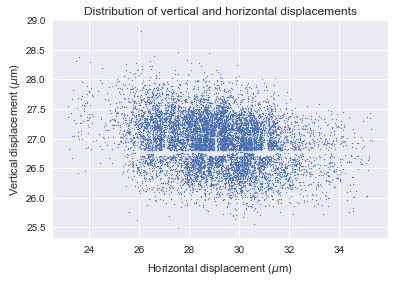

In [134]:
# set sane matplot settings
sns.set()

# visualize the distribution
plt.scatter(x, y, s=1);
plt.xlabel('Horizontal displacement ($\mu$m) \n' + distcap);
plt.ylabel('Vertical displacement ($\mu$m)');
plt.title('Distribution of vertical and horizontal displacements');

<a id='thermosc'></a>
#### Thermal & Oscillatory Motion

By constructing bins and fitting the counted number of occurrences into the bins, we can start to pick some meaning out of the data. You'll notice that at higher pressures the distribution is essentially gaussian. It is a great visual representation of the random walk of an atom!

In [135]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

def fit_gaussian(x, mu_guess, num_points=10000):
    bin_heights, bin_borders = np.histogram(x, bins='auto')
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[mu_guess, 0., 1.])

    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], num_points)
    return x_interval_for_fit, gaussian(x_interval_for_fit, *popt)

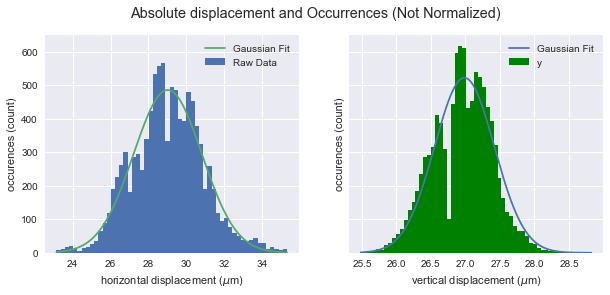

In [136]:
x_interval, x_gauss = fit_gaussian(x, mux)
y_interval, y_gauss = fit_gaussian(y, muy)

# build the fig and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# auto-choose bins
ax1.hist(x, 'auto', label='Raw Data')
ax1.plot(x_interval, x_gauss, label='Gaussian Fit')
ax1.set_xlabel("horizontal displacement ($\mu$m)")
ax1.set_ylabel("occurences (count)")
ax1.legend()

ax2.hist(y, 'auto', color='g')
ax2.plot(y_interval, y_gauss, label='Gaussian Fit')
ax2.set_xlabel("vertical displacement ($\mu$m)")
ax2.set_ylabel("occurences (count)")
ax2.legend()

fig.set_figwidth(10)
fig.suptitle("Absolute displacement and Occurrences (Not Normalized)");

<a id='kerden'></a>
#### Kernel Density Estimate

Using the Seaborn plotting library allows me to easily take this analysis one step farther. From the docs, the seaborn distplot function:

<blockquote>
combines the matplotlib ``hist`` function (with automatic
calculation of a good default bin size) with the seaborn `kdeplot`
and `rugplot` functions. It can also fit `scipy.stats`
distributions and plot the estimated PDF over the data.
</blockquote>

In other words, it will smooth and normalize the data. This doesn't add any real information; however, it does make the plots more fun to look at.

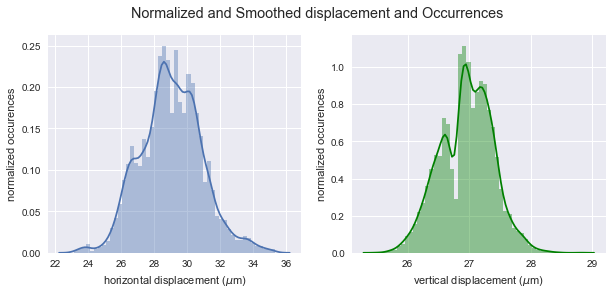

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2)
# normalized hist with a gaussian kenel density estimate
sns.distplot(x, ax=ax1)
sns.distplot(y, ax=ax2, color='g')

ax1.set_xlabel("horizontal displacement ($\mu$m)")
ax1.set_ylabel("normalized occurences")
ax2.set_xlabel("vertical displacement ($\mu$m)")
ax2.set_ylabel("normalized occurences")

fig.set_figwidth(10)
fig.suptitle("Normalized and Smoothed displacement and Occurrences");

#### Density Contour

If we combine the kernel density estimates from the previous plot, then we can generate a contour plot. Seaborn's "jointplot" does exactly this. I like this plot because it lets you see the hotspots - IE the places where the particle spends the most time during collection. 

<br>

Be careful though, artifacts could manifest in here as well. Structure does not necessarily imply an oscillatory or driven particle behavior.

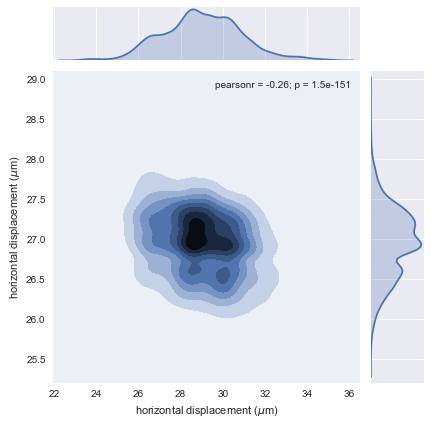

In [138]:
# a density contour plot of displacements
# IE joint probability and marginal combined
sns.jointplot(x, y, kind='kde').set_axis_labels(
    "horizontal displacement ($\mu$m)",
    "horizontal displacement ($\mu$m)");

<a id='jointprob'></a>
#### Joint Probability Distribution

This plot shows how a distribution changes from one point to the next. Mathematically, I am plotting

$$P(x_i(t), x_i(t + \Delta t))$$

and

$$P(y_i(t), y_i(t + \Delta t))$$

I do this by taking x[ i ] and plotting it against x[ i + n ] where "i" represents an element from the array of points gathered and "n" is some integer.

In [139]:
def plot_joint_dist(n):
    x_i = x[:-n]
    x_i_n = x[n:]
    y_i = y[:-n]
    y_i_n = y[n:]
    
    #build the axes
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.set_figheight(4.5)
    
    sns.regplot(x_i_n, x_i, scatter_kws={"s":1}, ax=ax1)
    sns.regplot(y_i_n, y_i, scatter_kws={"s":1}, ax=ax2)
    
    ax1.set_title('joint probability for x')
    ax1.set_xlabel('x[i] displacement ($\mu$m)')
    ax1.set_ylabel('x[i + n] displacement ($\mu$m)')

    ax2.set_title('joint probability for y')
    ax2.set_xlabel('y[i] displacement ($\mu$m)')
    ax2.set_ylabel('y[i + n] displacement ($\mu$m)')
    
    
    
j = widgets.interactive(
    plot_joint_dist, 
    n=widgets.IntSlider(min=1, max=25, step=1, value=1)
)

display(j)
    

interactive(children=(IntSlider(value=1, description='n', max=25, min=1), Output()), _dom_classes=('widget-int…

<a id='fourdom'></a>
#### Fourier Model

The final thing which we are asked to do is plot the distribution in the fourier domain. I made use of the fourierModel class that I wrote for the last lab. It uses SciPy's fft function.

<br>

For this lab, almost all of our data consists of 10,000 points spaced by 1/250th of a second. Unfortunately, the transient data was not great and we had to throw out over half of the frames.

<br>

This means that there is no good way to resolve the bins on the transient data. We don't have any sort of consistent time between measurements. So, take these graphs with a grain of salt for the transient data.

<br>

<a id='mass'></a>
#### Particle Mass

We can use the distribution to reconstruct the mass of the particle. From lecture we know that:

$$P(x) \propto e^{\frac{-m \omega_i^2 x_i^2}{2k_bT}}$$

So, using the standard gaussian distribution and equating the exponents we get:

$$ m =  \frac{k_bT}{\sigma^2 \omega_i^2 }$$

Using scipy's `norm.fit(distribution)` to extract $\sigma$ and getting $\omega$ by picking out the frequency of the largest peak in the fourier domain we can estimate the mass of our particles.

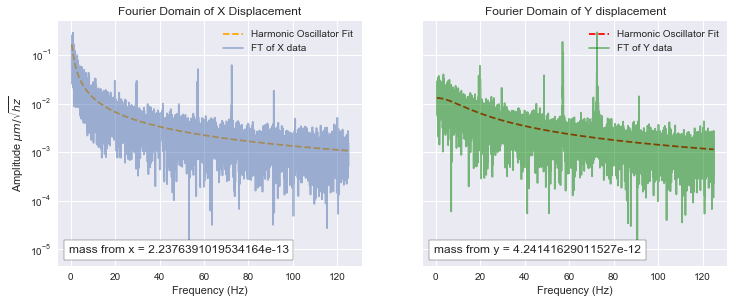

In [140]:
# FT the data
x_model = fourierModel(x, numPoints=x.shape[0])
x_x_ft = x_model.transformX()[20:]
x_y_ft = x_model.transformY()[20:]

y_model = fourierModel(y, numPoints=y.shape[0])
y_x_ft = y_model.transformX()[20:]
y_y_ft = y_model.transformY()[20:]

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

#Fit the FT as a HO
try:
    x_model_fit = lrcMultiFreqGain(x_x_ft, x_y_ft, yerr=None)
    xxfit, xyfit = x_model_fit.model(p0=[5, 10**-13, 50, 1])
    ax1.plot(xxfit, xyfit, '--', color='orange', label='Harmonic Oscillator Fit')
except RuntimeError:
    print('x fit did not converge')

try:
    y_model_fit = lrcMultiFreqGain(y_x_ft, y_y_ft, yerr=None)
    yxfit, yyfit = y_model_fit.model(p0=[5, 10**-13, 50, 1])
    ax2.plot(yxfit, yyfit, '--', color='r', label='Harmonic Oscillator Fit')
except RuntimeError:
    print('y fit did not converge')


ax1.set_xlabel('Frequency (Hz)');
ax1.set_ylabel('Amplitude $\mu m / \sqrt{hz}$')
ax1.set_title('Fourier Domain of X Displacement')
ax1.set_yscale('log')
ax1.plot(x_x_ft, x_y_ft, alpha=.5, label='FT of X data')
ax1.legend(loc=1)

ax2.set_xlabel('Frequency (Hz)');
ax2.set_title('Fourier Domain of Y displacement')
ax2.set_yscale('log')
ax2.plot(y_x_ft, y_y_ft, color='g', alpha=.5, label="FT of Y data")
ax2.legend(loc=1)

fig.set_figwidth(12)
fig.set_figheight(4.5)


# df with fourier data clipping off the ends
ftdf = pd.DataFrame({'xfreq': x_x_ft, 'xamp':x_y_ft, 'yfreq':y_x_ft, 'yamp':y_y_ft})
ftdf = ftdf.loc[(ftdf['xfreq'] > 40) & (ftdf['xfreq'] < 100)]

# get freq from peak to use with mass (use x)
wx = ftdf.loc[ftdf['xamp'].idxmax(), 'xfreq']
wy = ftdf.loc[ftdf['yamp'].idxmax(), 'yfreq']
kb = 1.38064852 * 10**(-23) 
T = 295 #room temp
massx = (kb * T) / ((sigmax / 10**6) * wx)**2
massy = (kb * T) / ((sigmay / 10**6) * wy)**2

# include particle mass
massx_text = AnchoredText("mass from x = " + str(massx), loc=3);
ax1.add_artist(massx_text);

massy_text = AnchoredText("mass from y = " + str(massy), loc=3);
ax2.add_artist(massy_text);


In [141]:
#mu / sqrt(hz) is my unit for y (ie amplitude spectrum)
#for driven, there is only a single frequency (so you can get it from the graph)
#thermal is peaked around zero

#ft is amplitude spectrum
#absolute value squared is power spectrum
#one peak is transverse motion, another is camera vibration

#averaging several measurements ought to be done in the power spectrum
#ie adding up should be done on squares (because noise is random)
#similarly, subracting off noise should be done in the power spectrum
#power spectrum good for noise driven

#coherent driving (ie known phase) can be done in amplitude spectrum

<a id='quests'></a>
### Questions

<a id='q1'></a>
#### High Vacuum Brownian Motion
- Using the oscillation frequencies measured under vacuum and the Brownian motion at or near atmospheric pressure, determine the mass of the particle from each of distributions. Assume that the temperature associated with the Brownian motion is 298 K. Why shouldn't you use the Brownian motion at high vacuum?

Secular motion --> thermal dominates at low vacuum but oscillation dominates at high vacuum.

<a id='q2'></a>
#### Diffusion Coefficients
- Determine the diffusion coefficient of a particle at several pressures using the joint probability distribution for both the vertical and axial motion.  Assume that the temperature associated with the Brownian motion is 298 K.

We will take $\Delta t$ to be 4 miliseconds. This corresponds to an offset of one frame given 250 frames per second. The first thing to do is model a linear regression and subtract off predicted values from actual values. This will give us a cluster of points that are all relatively close to zero. I make use of sklearn's `LinearRegression` class in order to build the model.

<br>
<hr>
<br>

Next, we can say from lecture that the diffusion coefficient 'D' is proportional to the distance of these points from zero:

$$ D \propto \frac{1}{N} \sum (\Delta x)^2$$

I think that it is unreasonable to expect an undergraduate course to treat a physical review article as though it were a textbook -- so, I will ignore the proportionality constant.  I am not familiar with this systems, but it seems possible that Brian misspoke and actually meant to say that it is proportional to the square roots:

$$ D_{alt} \propto \frac{1}{N} \sum \sqrt{(\Delta x)^2}$$

I'll go ahead and include both possibilities, just in case.

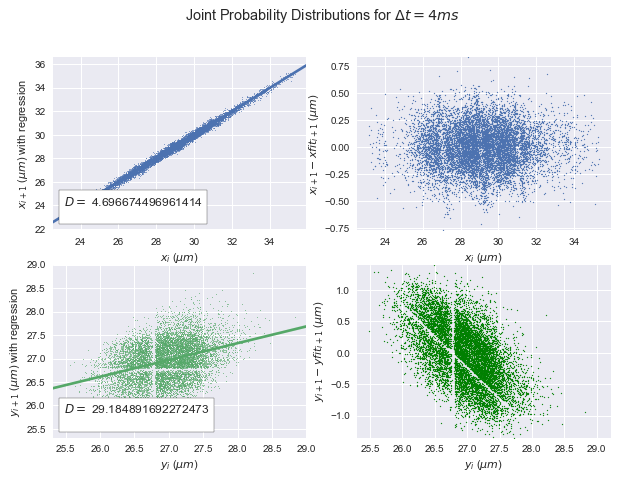

In [142]:
from sklearn.linear_model import LinearRegression
x_i = x[:-1]
x_i_n = x[1:]
y_i = y[:-1]
y_i_n = y[1:]

# build the model
model = LinearRegression(fit_intercept=True)
model.fit(x_i[:, np.newaxis], x_i_n)

# use it to predict the line values
xfit =  model.predict(x_i[:, np.newaxis])
yfit =  model.predict(y_i[:, np.newaxis])

# subtract off predictions from reality
xdif = x_i_n - xfit
ydif = y_i_n - yfit

# calculate the diffusion coefficients
dcoef_x = (xdif.apply(lambda x: x**2).sum() / len(xdif)) / (2 / 250)
dcoef_y = (ydif.apply(lambda x: x**2).sum() / len(ydif)) / (2 / 250)


# build the axes
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2,2, sharey=False)

# plot top left
sns.regplot(x_i, x_i_n, ax=ax1, scatter_kws={'s':1})
ax1.set_xlabel('$x_i$ ($\mu m$)')
ax1.set_ylabel('$x_{i+1}$ ($\mu m$) with regression')
ax1_text = AnchoredText(
    "$D = $ " + str(dcoef_x) + '\n', 3);
ax1.add_artist(ax1_text);

# top right
ax2.scatter(x_i, xdif, s=1);
ax2.set_ylim(min(xdif), max(xdif))
ax2.set_xlabel('$x_i$ ($\mu m$)')
ax2.set_ylabel('$x_{i+1} - xfit_{i+1}$ ($\mu m$)')

# bottom left
sns.regplot(y_i, y_i_n, ax=ax3, scatter_kws={'s':1})
ax3_text = AnchoredText(
    "$D = $ " + str(dcoef_y) + '\n', 3);
ax3.add_artist(ax3_text);
ax3.set_xlabel('$y_i$ ($\mu m$)')
ax3.set_ylabel('$y_{i+1}$ ($\mu m$) with regression')

# bottom right
ax4.scatter(y_i, y_i_n - yfit, s=1, c='g');
ax4.set_ylim(min(ydif), max(ydif))
ax4.set_xlabel('$y_i$ ($\mu m$)')
ax4.set_ylabel('$y_{i+1} - yfit_{i+1}$ ($\mu m$)')

fig.suptitle('Joint Probability Distributions for $\Delta t = 4 ms$')
fig.set_figwidth(10)
fig.set_figheight(7)

<a id='q3'></a>
#### Purpose of Brownian Measurements
- What can you learn about a particular trapped particle from the Brownian motion measurements?

diffusion coefficient at high pressure
mass and frequency at low pressure
.............

<a id='q4'></a>
#### Harmonic Oscillation
 - Compare the thermally-driven, coherently-driven, and transient responses in the Fourier domain at all pressures measured. In each case, carefully fit the particle motion to a harmonic oscillator model, and compare the results.
 
 uhhhh

<a id='q5'></a>
#### Quality Factor
- From your Fourier domain analysis, plot the dependence of the the quality factor (Q) of the particle motion on pressure.

should go like 1 / p

In [143]:
qualities = [681.2140266021546,
             1038.4217311232949,
             978.0953206238477,
             709.3739021330393,
             684.0706455542276]
pressures = [620, 284, 94.5, .839, .0000314]

(1e-06, 1000)

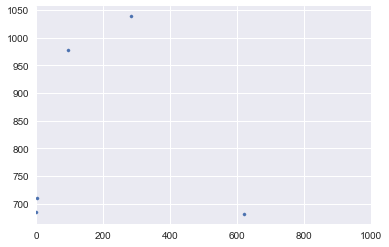

In [144]:
plt.scatter(pressures, qualities, s=10)
plt.xlim(.000001, 1000)